In [1]:
import pandas as pd
from sklearn.preprocessing import Normalizer, StandardScaler
import xgboost as xgb

In [2]:
from libs.predictor_util import modelfit
from libs.plot_utils import plot_confusion_matrix, analysing_feature_importance
from libs.transformer_utils import process_features_standardisation, encode_labels, one_hot_encode_field

## 1. Load the Data set

In [3]:
df = pd.read_csv('../data/outputs/06_final_dataset.csv')

In [4]:
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,statusId,year,round,circuitId,...,race_end_in_2019,race_end_in_2020,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_most_won_circuit_id,driver_nber_of_races_won,driver_nber_of_times_in_top_10,age,season_age
0,1,18,1,1,1,2,1,2008,1,1,...,21,16,21,19,12,14,63,292,39,23
1,2,18,2,2,5,3,1,2008,1,1,...,0,0,0,0,0,2,2,131,47,31
2,3,18,3,3,7,5,1,2008,1,1,...,0,0,0,0,0,3,20,158,39,23
3,4,18,4,4,11,7,1,2008,1,1,...,0,0,11,12,12,9,22,285,43,27
4,5,18,5,1,3,1,1,2008,1,1,...,0,0,0,0,0,1,2,37,43,27


In [5]:
df.shape

(26080, 28)

In [6]:
df_rank_zero = df[(df['race_rank'] == 0) & (df['year'] > 2010)]
print(df_rank_zero.shape)
df = df[(df['race_rank'] != 0) & (df['year'] > 206)]
df = pd.concat([df, df_rank_zero], ignore_index=True)

(216, 28)


In [7]:
# to_one_enc = ['grid', 'statusId']
to_one_enc = ['grid', 'circuitId', 'constructor_is_active', 'driver_is_active']

In [8]:
for field in to_one_enc:
    df = one_hot_encode_field(df, field)

## 2. Encode categorials variables

In [9]:
cat_cols = ['race_rank', 'constructorId', 'driverId', 'statusId', 'driver_most_won_circuit_id', 'round']

In [10]:
df = encode_labels(df, cat_cols)

## 3. Normalizing columns

In [11]:
cols = ['year', 'driver_avg_point', 'race_end_bf_2019', 'driver_nber_of_races_won',
        'race_end_in_2019', 'race_end_in_2020', 'race_end_in_2021', 'race_end_in_2022', 'race_end_in_2023']
df[cols] = process_features_standardisation(df, cols, Normalizer)

In [12]:
bins = [df['driver_avg_speed'].min(), 200, 202, 204, 206, df['driver_avg_speed'].max()]
labels = [1, 2, 3, 4, 5]
categories = pd.cut(df['driver_avg_speed'], bins=bins, labels=labels, include_lowest=True)
df['driver_avg_speed'] = categories

In [13]:
bins = [df['constructor_avg_point'].min(), 2, 6, 8, 10, df['constructor_avg_point'].max()]
labels = [1, 2, 3, 4, 5]
categories = pd.cut(df['constructor_avg_point'], bins=bins, labels=labels, include_lowest=True)
df['constructor_avg_point'] = categories


## 4. Delete unused columns

In [14]:
df.drop(['raceId', 'resultId', 'age', 'driver_avg_point', 'year', 'race_end_bf_2019'], axis=1, inplace=True)

In [15]:
df_to_predict_later = df.iloc[:15]
df = df.iloc[16:]
df.head()


,driverId,constructorId,race_rank,statusId,round,constructor_races_won,constructor_avg_point,constructor_times_in_top_10,driver_avg_speed,race_end_in_2019,...,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79,constructor_is_active_1,driver_is_active_1
16,21,10,8,1,0,0,1,88,4,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,7,5,2,0,1,92,2,2251,5,0.002972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18,8,1,6,0,1,2,2,98,3,0.000996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,4,0,7,0,1,50,2,1571,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20,14,6,8,0,1,3,1,175,2,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Fit the model

In [16]:
target = 'race_rank'
id_col = 'resultId'
features = [x for x in df.columns if x not in [target, id_col]]

In [17]:
xgb_model = xgb.XGBClassifier(
    n_estimators=205,
    learning_rate=0.001,
    max_depth=120,
    eta= 0.18,
    subsample= .8,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80,
)
# best_params = {'colsample_bytree': 0.8, 'eta': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 205, 'objective': 'multi:softmax', 'seed': 80, 'subsample': 0.5}

In [18]:
model = modelfit(df, features, target, xgb_model)


Model Report
Accuracy : 0.1237
AUC Score (Train): 0.857698
AUC Score (Test): 0.759754


## 6. Analysing the model output

### 6.1. Classification report

In [19]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.69      0.38        68
           1       0.22      0.27      0.24       118
           2       0.18      0.23      0.20       116
           3       0.12      0.19      0.15       106
           4       0.14      0.13      0.13       112
           5       0.07      0.04      0.05       112
           6       0.03      0.02      0.03       121
           7       0.07      0.08      0.08       105
           8       0.06      0.06      0.06       112
           9       0.07      0.08      0.07       104
          10       0.12      0.06      0.08       109
          11       0.10      0.09      0.09       115
          12       0.08      0.11      0.10        97
          13       0.02      0.01      0.01       123
          14       0.12      0.10      0.11       124
          15       0.11      0.04      0.06       104
          16       0.10      0.16      0.13       102
    

In [20]:
import numpy as np
classification_report_lines = model[4].strip().split('\n')[2:-4]
precision, recall, f1, support = [], [], [], []
for line in classification_report_lines:
    print(line)
    line = line.split()
    precision.append(float(line[1]))
    recall.append(float(line[2]))
    f1.append(float(line[3]))
    support.append(int(line[4]))

# Calcul des poids de classe inverses
class_weights = np.sum(support) / (len(support) * np.array(support))

           0       0.26      0.69      0.38        68
           1       0.22      0.27      0.24       118
           2       0.18      0.23      0.20       116
           3       0.12      0.19      0.15       106
           4       0.14      0.13      0.13       112
           5       0.07      0.04      0.05       112
           6       0.03      0.02      0.03       121
           7       0.07      0.08      0.08       105
           8       0.06      0.06      0.06       112
           9       0.07      0.08      0.07       104
          10       0.12      0.06      0.08       109
          11       0.10      0.09      0.09       115
          12       0.08      0.11      0.10        97
          13       0.02      0.01      0.01       123
          14       0.12      0.10      0.11       124
          15       0.11      0.04      0.06       104
          16       0.10      0.16      0.13       102
          17       0.09      0.09      0.09       102
          18       0.22     

In [21]:
model = modelfit(df, features, target, xgb_model, class_weights)

IndexError: index 24 is out of bounds for axis 0 with size 24

In [ ]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.76      0.42        59
           1       0.16      0.29      0.21        96
           2       0.13      0.25      0.17        81
           3       0.12      0.12      0.12        97
           4       0.13      0.14      0.13        86
           5       0.08      0.05      0.06       106
           6       0.05      0.03      0.04       104
           7       0.18      0.12      0.14       107
           8       0.12      0.04      0.06       112
           9       0.09      0.12      0.10        86
          10       0.08      0.06      0.07        88
          11       0.05      0.04      0.05        93
          12       0.10      0.12      0.11        92
          13       0.04      0.04      0.04        84
          14       0.09      0.08      0.08        88
          15       0.09      0.07      0.08        86
          16       0.05      0.03      0.04       111
    

### 6.2. Confuxion Matrix

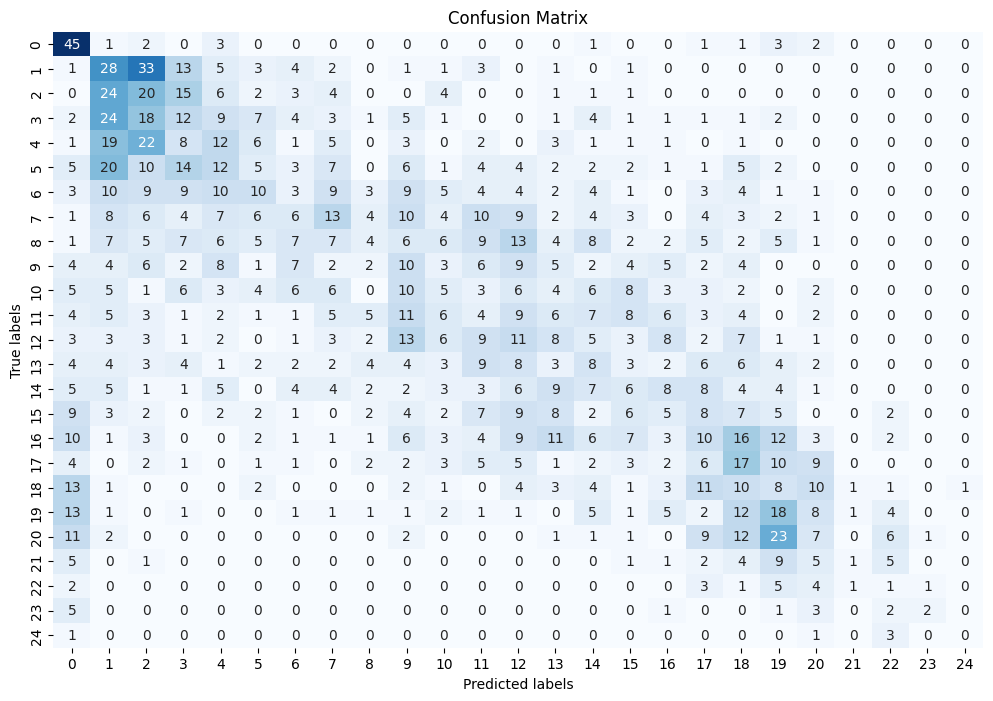

In [ ]:
plot_confusion_matrix((model[1], model[2]))

### 6.4. Feature importance

In [ ]:
feature_imp_serie = pd.Series(model[0].get_booster().get_fscore()).sort_values(ascending=False)

In [ ]:
analysing_feature_importance(feature_imp_serie)

## 7. Test the model with specifics data

In [ ]:
df_to_predict_later.iloc[5:13]

,driverId,constructorId,race_rank,statusId,round,constructor_races_won,constructor_avg_point,constructor_times_in_top_10,driver_avg_speed,race_end_in_2019,...,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79,constructor_is_active_1,driver_is_active_1
5,5,2,14,10,0,7,2,1170,2,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,6,4,12,4,0,1,1,208,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,5,4,4,0,92,2,2251,5,0.002972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,8,1,9,3,0,2,2,98,3,0.000996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,6,13,2,0,3,1,175,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,10,7,15,6,0,0,1,9,5,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,11,3,16,7,0,14,2,576,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,12,5,6,4,0,92,2,2251,3,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
model[0].predict(df_to_predict_later.iloc[5:13].drop('race_rank', axis=1))

array([17, 17,  1,  0, 20, 19, 17,  7], dtype=int32)